In [1]:
#確認TF版本
# Install TensorFlow
#!pip install -q tensorflow-gpu==2.2.0

#try:
#  %tensorflow_version 2.x
#except Exception:
#  pass

import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [3]:
# URL  與 pd.read_csv 不直接相容
!wget -nc https://raw.githubusercontent.com/shawjiunchen/aitf20/master/spam.csv

--2020-09-25 07:15:55--  https://raw.githubusercontent.com/shawjiunchen/aitf20/master/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.03s   

2020-09-25 07:15:55 (14.6 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
#!head spam.csv

In [5]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
# 丟掉無用欄位
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# 重新命名
df.columns = ['labels', 'data']

In [10]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# 二元標籤
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [12]:
# 訓練與測試數據分離
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [13]:
# 將句子轉成序列
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [14]:
# 從 word -> integer 映射
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7235 unique tokens.


In [15]:
# pad 序列 得到 N x T 矩陣
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# 序列長度
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [16]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [17]:
# 建立模型

# 決定 embedding dimensionality
D = 20

# 決定 Hidden state dimensionality
M = 15

# Note: 我們要的  embedding 大小 是 (V + 1) x D,
# 因為第一個 index 從 1 而非 0開始.


i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)


In [18]:
# 編譯與訓練
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
117/117 [==============================] - 2s 15ms/step - loss: 0.4775 - accuracy: 0.8430 - val_loss: 0.3854 - val_accuracy: 0.8706
Epoch 2/10
117/117 [==============================] - 1s 12ms/step - loss: 0.3986 - accuracy: 0.8636 - val_loss: 0.3854 - val_accuracy: 0.8706
Epoch 3/10
117/117 [==============================] - 1s 12ms/step - loss: 0.3969 - accuracy: 0.8636 - val_loss: 0.3798 - val_accuracy: 0.8706
Epoch 4/10
117/117 [==============================] - 1s 12ms/step - loss: 0.3554 - accuracy: 0.8636 - val_loss: 0.3134 - val_accuracy: 0.8706
Epoch 5/10
117/117 [==============================] - 1s 12ms/step - loss: 0.2955 - accuracy: 0.8636 - val_loss: 0.2566 - val_accuracy: 0.8706
Epoch 6/10
117/117 [==============================] - 1s 12ms/step - loss: 0.1929 - accuracy: 0.9188 - val_loss: 0.1256 - val_accuracy: 0.9744
Epoch 7/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0624 - accuracy: 0.9928 - val_loss: 0.0524 - va

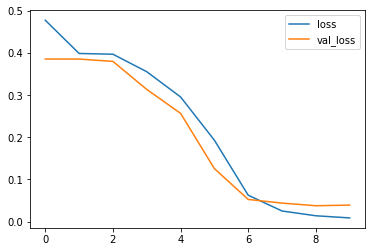

In [19]:
# 迭代損失函數
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

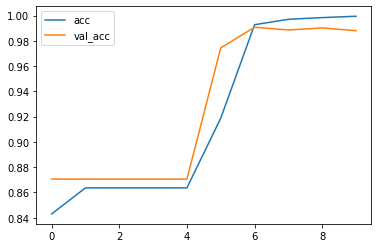

In [20]:
# 迭代準確度
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()